In [5]:
import numpy as np
import pandas as pd

In [6]:
import torch

data_path = "../data/reduced_train_test_split//"

X_test_tensor = torch.load(data_path + "X_test.pt")
y_test_tensor = torch.load(data_path + "y_test.pt")

test_inputs: list[np.ndarray] = pd.read_pickle(data_path + "X_test.pkl").tolist()
targets: list[int] = pd.read_pickle(data_path + "y_test.pkl").tolist()

print(X_test_tensor[:5])
print(y_test_tensor[:5])
print(test_inputs[:5])
print(targets)

C:\Users\gurgel\AppData\Local\Temp\ipykernel_2980\2400429425.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_test_tensor = torch.load(data_path + "X_test.pt")
C:\Users

tensor([[ 4.6000e+01, -2.1376e-01, -2.7302e-01, -2.0079e-01, -2.5825e-01,
         -2.2256e-01, -2.2331e-01, -2.3894e-01, -2.1736e-01, -2.6441e-01,
         -2.9630e-01, -3.0502e-01, -3.1973e-01, -3.3386e-01, -4.1456e-01,
         -5.3597e-01, -5.1459e-01, -6.9175e-01, -7.1675e-01, -8.0627e-01,
         -9.0755e-01, -1.0729e+00, -1.0910e+00, -1.0705e+00, -1.1965e+00,
         -1.1417e+00,  1.7860e-01, -1.1587e+00, -1.1264e+00, -1.2403e+00,
         -1.0887e+00, -1.0940e+00, -1.0269e+00, -9.9988e-01, -1.0091e+00,
         -9.9629e-01, -9.2584e-01, -8.4365e-01, -9.1054e-01, -8.1281e-01,
         -7.9621e-01, -6.8563e-01, -7.5986e-01, -7.2482e-01, -6.5276e-01,
         -6.0489e-01, -6.4545e-01, -5.5362e-01, -5.5409e-01, -5.8791e-01,
         -5.9253e-01, -5.4771e-01, -1.1744e+00, -1.1432e+00],
        [ 1.0000e+01, -1.2046e+00, -1.1377e+00, -1.1721e+00, -1.0619e+00,
         -9.7694e-01, -9.8520e-01, -9.1527e-01, -8.7708e-01, -8.2514e-01,
         -7.6225e-01, -7.4898e-01, -6.0825e-01, -7

In [7]:
from torch.utils.data import DataLoader, TensorDataset

inputs = X_test_tensor.shape[1]
batch_size = 512
num_workers = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

print(test_loader.dataset.tensors)

(tensor([[46.0000, -0.2138, -0.2730,  ..., -0.5477, -1.1744, -1.1432],
        [10.0000, -1.2046, -1.1377,  ...,  0.5050, -1.1571, -1.1429],
        [33.0000, -1.7444, -1.7738,  ...,  0.8641,  1.2261,  1.2260],
        ...,
        [35.0000,  1.3852,  1.5208,  ...,  1.7421, -1.1643, -1.1480],
        [56.0000, -0.8822, -0.9156,  ...,  0.6520, -1.1681, -1.1030],
        [43.0000, -0.1381, -0.1438,  ..., -0.2081, -1.1750, -1.1440]]), tensor([13, 10,  0,  ..., 16,  3,  5]))


In [8]:
from mlp import CsiNeuralNet

state_file = "mlp/reduced_model.pth"

net = CsiNeuralNet(inputs, device, state_file)
predictions, accuracy = net.test_model(test_loader)

c:\Users\gurgel\Desktop\Personal\Projects\UFF\Mestrado\Telecom\csi\models\mlp.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(state_file

Testing on device: cuda
Accuracy: 86.02%, In 9.30s


              0       1       2       3       4       5       6       7   \
Accuracy  98.95%  93.72%  93.81%  77.72%  96.80%  96.13%  90.17%  89.55%   

              8       9       10      11      12      13      14      15  \
Accuracy  93.18%  91.68%  97.62%  97.42%  97.72%  97.25%  84.14%  51.45%   

              16      17  
Accuracy  46.01%  56.32%  


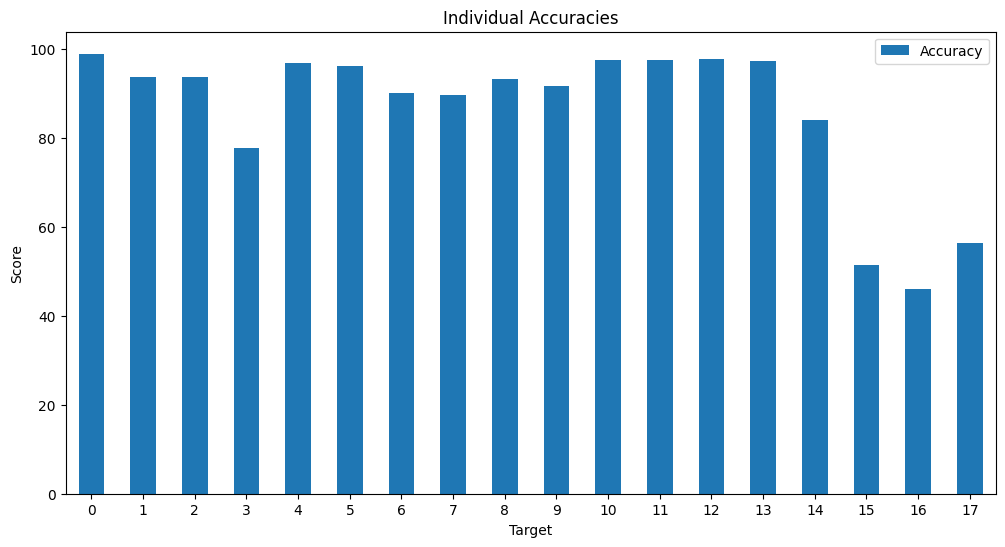

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

correct_pred = {}
total_pred = {}
accuracies = {}
num_positions = 18

for i, t in enumerate(targets):
    total_pred[t] = total_pred.get(t, 0) + 1

    if predictions[i] == t:
        correct_pred[t] = correct_pred.get(t, 0) + 1

for target in range(num_positions):
    accuracies[target] = (correct_pred[target] / total_pred[target]) * 100

data = {"Accuracy": accuracies}
df = pd.DataFrame(data)
df_plot = df.copy()

df["Accuracy"] = df["Accuracy"].map("{:.2f}%".format)
print(df.T)

df_plot.plot(kind="bar", figsize=(12, 6))
plt.title("Individual Accuracies")
plt.xlabel("Target")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

In [10]:
sum_probabilities = [0.0] * num_positions
sum_correct_probabilities = [0.0] * num_positions
sum_wrong_probabilities = [0.0] * num_positions
prediction_counts = [0] * num_positions
correct_counts = [0] * num_positions
wrong_counts = [0] * num_positions

num_bins = 101
total_bins = [0] * num_bins
total_correct_bins = [0] * num_bins
pos_bins = [[0] * num_bins for _ in range(num_positions)]
pos_correct_bins = [[0] * num_bins for _ in range(num_positions)]

for x, y in zip(test_inputs, targets):
    state = torch.tensor([x], dtype=torch.float32).to(device)
    net.to(device)
    probabilities = net.get_position_probabilities(state)

    max_prob = max(probabilities)
    prediction = probabilities.index(max_prob)

    prediction_counts[prediction] += 1
    sum_probabilities[prediction] += max_prob

    bin_index = int(max_prob * 100)
    total_bins[bin_index] += 1
    pos_bins[prediction][bin_index] += 1

    if prediction == y:
        sum_correct_probabilities[prediction] += max_prob
        correct_counts[prediction] += 1
        total_correct_bins[bin_index] += 1
        pos_correct_bins[prediction][bin_index] += 1
    else:
        sum_wrong_probabilities[prediction] += max_prob
        wrong_counts[prediction] += 1

In [11]:
average_total_probabilities = []
average_correct_probabilities = []
average_wrong_probabilities = []

for i in range(num_positions):
    average_total_probabilities.append(
        sum_probabilities[i] / prediction_counts[i] if prediction_counts[i] != 0 else 0
    )
    average_correct_probabilities.append(
        sum_correct_probabilities[i] / correct_counts[i]
        if correct_counts[i] != 0
        else 0
    )
    average_wrong_probabilities.append(
        sum_wrong_probabilities[i] / wrong_counts[i] if wrong_counts[i] != 0 else 0
    )

print(average_total_probabilities)
print(average_correct_probabilities)
print(average_wrong_probabilities)

[0.9857493227166394, 0.9246644242003784, 0.9286794668921815, 0.8158769046510743, 0.9534866003705401, 0.9451460189263545, 0.8862158913396426, 0.8733205652811441, 0.9045171888743961, 0.8813212035219374, 0.9727169610758521, 0.977045047700676, 0.9744282362705784, 0.9714968118796896, 0.875086259471576, 0.5961945598921835, 0.5914402486983671, 0.6664299988887236]
[0.9921213355957083, 0.9478451518374239, 0.9543461296428164, 0.8672732892306386, 0.9719050936960325, 0.9641872429290311, 0.9227756717869708, 0.9115187129476897, 0.938337383844075, 0.9186462617647826, 0.9852883547685437, 0.9867193473176705, 0.9853295069790944, 0.9809291898093592, 0.9192558605132745, 0.652762674356193, 0.640950665080991, 0.7389070552952702]
[0.7131673557758331, 0.6417458762098875, 0.622172102026276, 0.6064216618528178, 0.6651597188733448, 0.6685200637264407, 0.6352071642965498, 0.6110801462733606, 0.6314450744184779, 0.6178820243296828, 0.6757893684015098, 0.6552970433394417, 0.6860617760686689, 0.637886068171428, 0.59

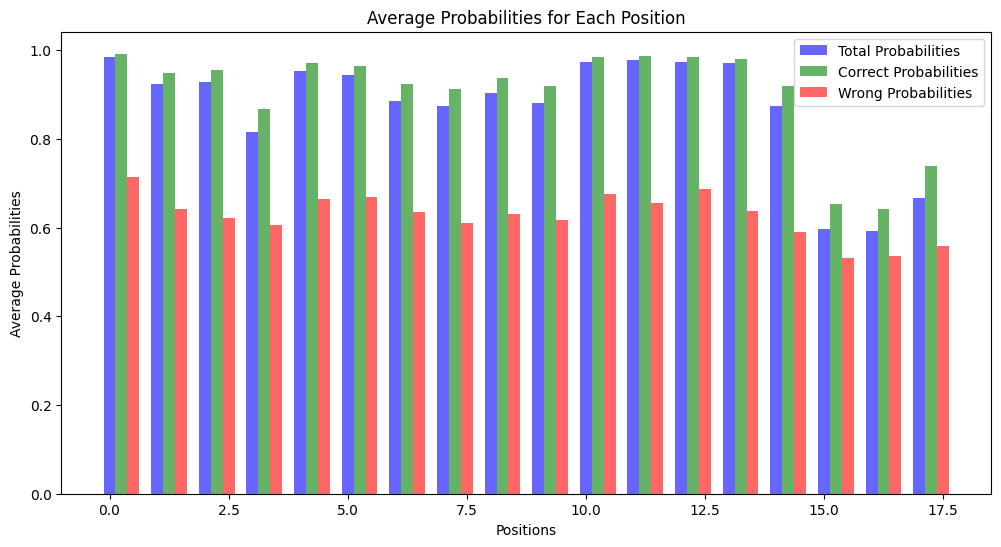

In [12]:
bar_width = 0.25

positions = np.arange(num_positions)
positions_total = positions
positions_correct = positions + bar_width
positions_wrong = positions + 2 * bar_width

plt.figure(figsize=(12, 6))
plt.bar(
    positions_total,
    average_total_probabilities,
    width=bar_width,
    color="blue",
    alpha=0.6,
    label="Total Probabilities",
)
plt.bar(
    positions_correct,
    average_correct_probabilities,
    width=bar_width,
    color="green",
    alpha=0.6,
    label="Correct Probabilities",
)
plt.bar(
    positions_wrong,
    average_wrong_probabilities,
    width=bar_width,
    color="red",
    alpha=0.6,
    label="Wrong Probabilities",
)
plt.xlabel("Positions")
plt.ylabel("Average Probabilities")
plt.title("Average Probabilities for Each Position")
plt.legend()
plt.show()

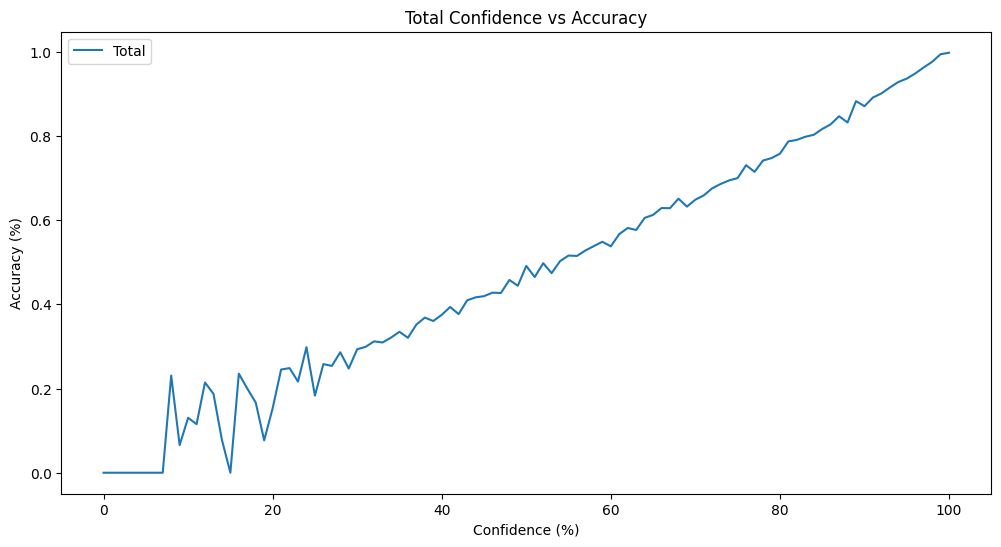

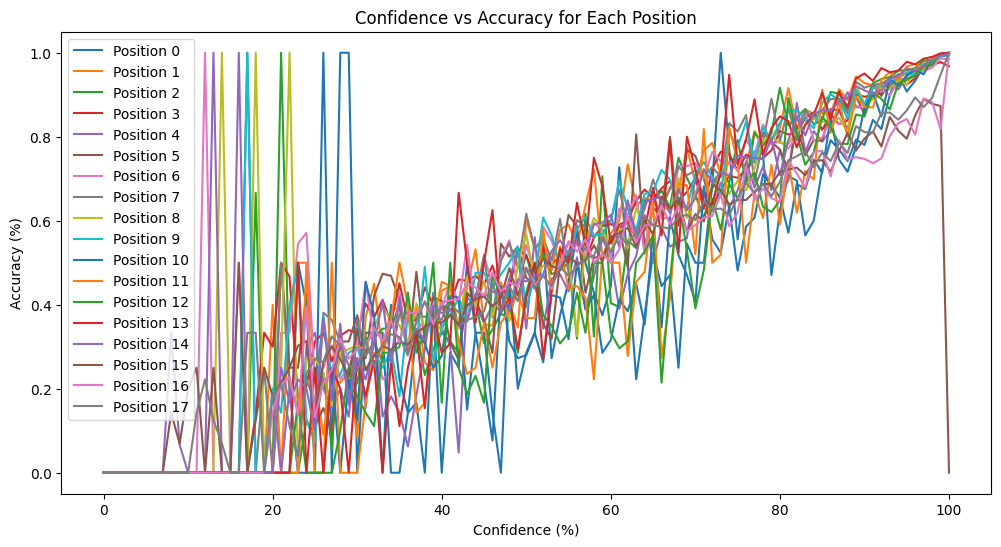

In [13]:
total_accuracy_bins = [0] * num_bins
pos_accuracy_bins = [[0] * num_bins for _ in range(num_positions)]

for i in range(num_bins):
    total_accuracy_bins[i] = (
        total_correct_bins[i] / total_bins[i] if total_bins[i] != 0 else 0
    )
    for j in range(num_positions):
        pos_accuracy_bins[j][i] = (
            pos_correct_bins[j][i] / pos_bins[j][i] if pos_bins[j][i] != 0 else 0
        )

# Plot the total confidence/accuracy relation
plt.figure(figsize=(12, 6))
plt.plot(range(num_bins), total_accuracy_bins, label="Total")
plt.xlabel("Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Total Confidence vs Accuracy")
plt.show()

# Plot the confidence/accuracy relation for each individual position
plt.figure(figsize=(12, 6))
for pos in range(num_positions):
    plt.plot(range(num_bins), pos_accuracy_bins[pos], label=f"Position {pos}")
plt.xlabel("Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Confidence vs Accuracy for Each Position")
plt.show()

In [14]:
input_to_hidden1_weights = net.fc1.weight.data
hidden1_to_hidden2_weights = net.fc2.weight.data
hidden2_to_output_weights = net.output.weight.data

impact_matrix = torch.matmul(
    hidden2_to_output_weights,
    torch.matmul(hidden1_to_hidden2_weights, input_to_hidden1_weights),
)

# Convert the impact matrix to a numpy array for easier analysis
impact_matrix = impact_matrix.cpu().numpy()

# Print the impact matrix
print("Impact matrix (rows: output nodes, columns: input nodes):")
print(f"Shape: {impact_matrix.shape}")
print(impact_matrix)

# Identify the most impactful input nodes for each output node
most_impactful_inputs = impact_matrix.argmax(axis=1)
print("Most impactful input nodes for each output node:")
print(most_impactful_inputs)

Impact matrix (rows: output nodes, columns: input nodes):
Shape: (18, 54)
[[-1.35256897e+02 -2.89609650e+02 -3.22757019e+02 -2.38050446e+02
  -1.99110443e+02 -1.45682343e+02 -6.59459763e+01  1.41905689e+00
   2.38065720e+01  9.45353928e+01  1.23334030e+02  1.20370705e+02
   1.75103058e+02  1.53847778e+02  1.08516685e+02  1.96753349e+01
  -7.21530914e-02 -2.00516853e+01 -4.34475174e+01 -6.03395119e+01
  -7.82670212e+01 -1.45023911e+02 -9.67676392e+01 -7.06800308e+01
  -1.00947857e+01 -3.91131706e+01 -3.68657112e-01  1.80652580e+01
  -4.42332001e+01 -2.43295898e+01  7.66283875e+01  5.95266609e+01
   2.41115894e+01  5.47681952e+00  9.09775467e+01  4.54987755e+01
   1.15917412e+02  1.28682343e+02  1.22188736e+02  7.25614929e+01
   9.05917740e+01  9.07241287e+01  2.78391876e+01 -3.02635632e+01
  -4.05116501e+01 -8.40719223e+01 -1.53282791e+02 -1.56550354e+02
  -1.68199539e+02 -2.15438232e+02 -1.78049774e+02 -2.02146820e+02
   2.61611969e+02  1.26359146e+02]
 [-1.39253662e+02 -1.46658203e+02

In [15]:
data_path = "../data/combined/"
data_file = "amplitude_csi_dataframe.pkl"

TARGET_VARIABLE = "position"
STATE = 42

# Use same subcarrier range as the trained model
min_subcarrier = 0
max_subcarrier = 60

data_df: pd.DataFrame = pd.read_pickle(data_path + data_file)
columns_to_drop = [
    col
    for col in data_df.columns
    if isinstance(col, (int)) and (col > max_subcarrier or col < min_subcarrier)
]

data_df.drop(columns=columns_to_drop, inplace=True)
data_df.drop(columns=[TARGET_VARIABLE], inplace=True)

input_labels = data_df.columns
total_columns = len(input_labels)

print(f"Total columns: {total_columns}")
print(input_labels)

Total columns: 54
Index(['person',        6,        7,        8,        9,       10,       11,
             12,       13,       14,       15,       16,       17,       18,
             19,       20,       21,       22,       23,       24,       26,
             27,       28,       29,       30,       31,       32,       33,
             34,       35,       36,       37,       38,       39,       40,
             41,       42,       43,       44,       45,       46,       47,
             48,       49,       50,       51,       52,       54,       55,
             56,       57,       58,       59,       60],
      dtype='object')


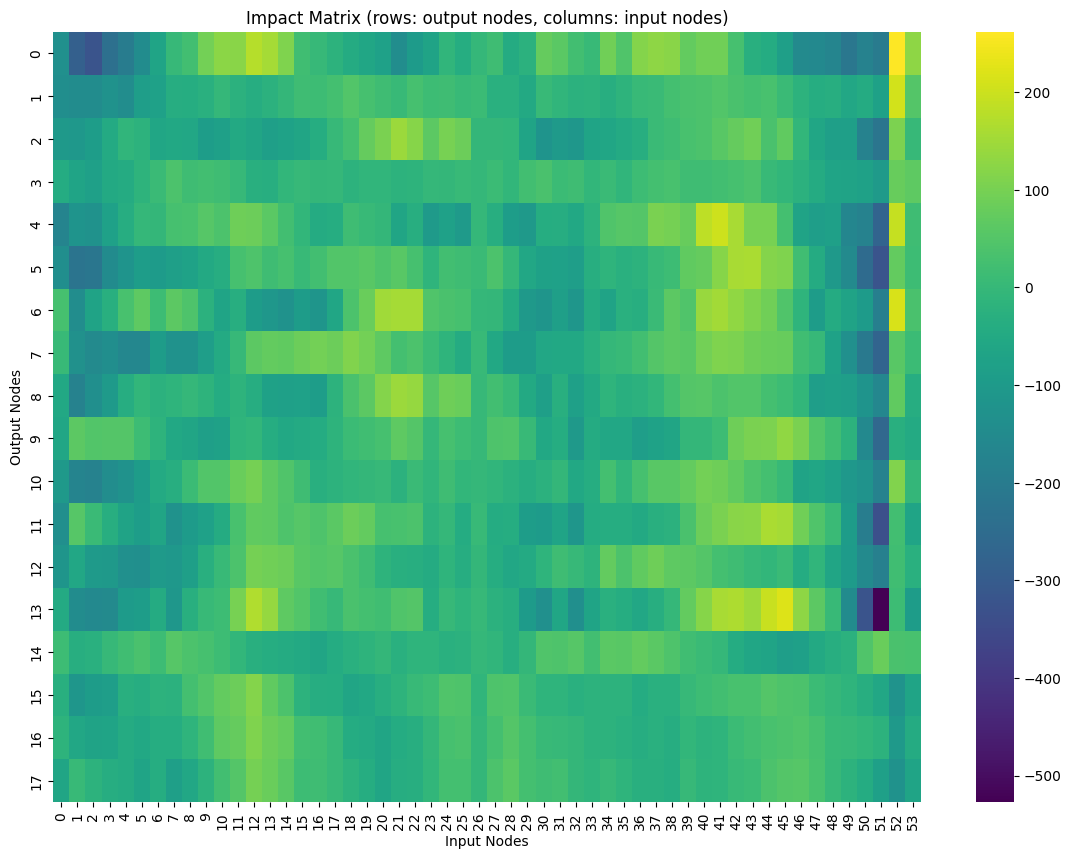

In [16]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    impact_matrix,
    annot=False,
    cmap="viridis",
    cbar=True,
    # xticklabels=input_labels,
)
plt.title("Impact Matrix (rows: output nodes, columns: input nodes)")
plt.xlabel("Input Nodes")
plt.ylabel("Output Nodes")
plt.show()